In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
##Load and normalizing datasets
class DefaultConfigs(object):
    image_size = 32 
    batch_size = 40 
    channels = 3
    use_gpu = torch.cuda.is_available()

config = DefaultConfigs()
config.use_gpu = True
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


trainset = torchvision.datasets.ImageFolder('/Users/yuqinhan1229/Desktop/train',
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.Resize((config.image_size, config.image_size)),
                                           torchvision.transforms.CenterCrop(config.image_size),
                                           torchvision.transforms.ToTensor(),
                                           normalize])
                                       )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

 
testset = torchvision.datasets.ImageFolder('/Users/yuqinhan1229/Desktop/test',
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.Resize((config.image_size, config.image_size)),
                                           torchvision.transforms.CenterCrop(config.image_size),
                                           torchvision.transforms.ToTensor(),
                                           normalize])
                                       )
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('cat','dog','wild')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


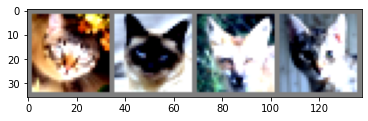

  cat        cat       wild        cat


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# print image
def show(img):
    img = img/2+0.5
    npimg = img.numpy()
    im = plt.imshow(np.transpose(npimg, (1,2,0)),cmap=plt.cm.binary)
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
show(torchvision.utils.make_grid(images))
print('      '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
##build cnn2 (Three fully connected layers)
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net1()

In [5]:
# loss function&optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [6]:
# train the CNN1
for epoch in range(10): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.807
[2,  2000] loss: 0.325
[3,  2000] loss: 0.227
[4,  2000] loss: 0.171
[5,  2000] loss: 0.143
[6,  2000] loss: 0.108
[7,  2000] loss: 0.092
[8,  2000] loss: 0.069
[9,  2000] loss: 0.066
[10,  2000] loss: 0.051
Finished Training


Text(0, 0.5, 'Loss')

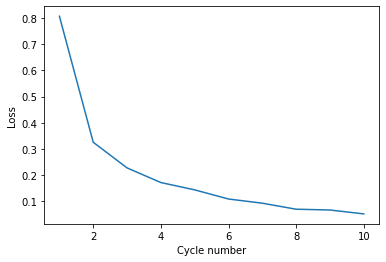

In [43]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [0.807,0.325,0.227,0.171,0.143,0.108,0.092,0.069,0.066,0.051]
plt.plot(x, y)
plt.xlabel('Cycle number')
plt.ylabel('Loss')

In [8]:
PATH = '/Users/yuqinhan1229/Desktop/cifar_net.pth'
torch.save(net1.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


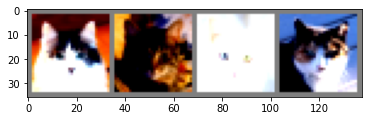

GroundTruth:    cat   cat   cat   cat


In [9]:
# test the CNN
dataiter = iter(testloader)
images, labels = dataiter.next()


show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net1 = Net1()
net1.load_state_dict(torch.load(PATH))
outputs = net1(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   cat   cat   cat


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 94 %


In [12]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 96 %
Accuracy of   dog : 96 %
Accuracy of  wild : 90 %


In [28]:
##build cnn (Two fully connected layers)
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net2 = Net2()

In [29]:
# loss function&optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [30]:
# train the CNN2
for epoch in range(10): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.706
[2,  2000] loss: 0.286
[3,  2000] loss: 0.200
[4,  2000] loss: 0.165
[5,  2000] loss: 0.141
[6,  2000] loss: 0.109
[7,  2000] loss: 0.094
[8,  2000] loss: 0.081
[9,  2000] loss: 0.064
[10,  2000] loss: 0.061
Finished Training


Text(0, 0.5, 'Loss')

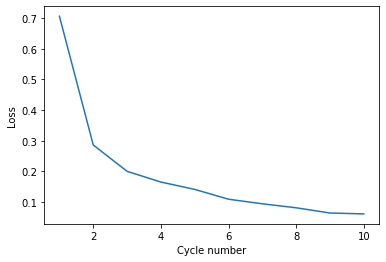

In [44]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [0.706,0.286,0.200,0.165,0.141,0.109,0.094,0.081,0.064,0.061]
plt.plot(x, y)
plt.xlabel('Cycle number')
plt.ylabel('Loss')

In [31]:
PATH = '/Users/yuqinhan1229/Desktop/cifar_net2.pth'
torch.save(net2.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


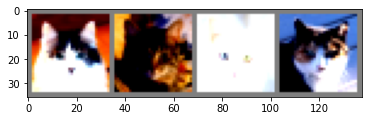

GroundTruth:    cat   cat   cat   cat


In [32]:
# test the CNN
dataiter = iter(testloader)
images, labels = dataiter.next()


show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [35]:
net2 = Net2()
net2.load_state_dict(torch.load(PATH))
outputs = net2(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   cat   cat   cat


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 93 %


In [37]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 93 %
Accuracy of   dog : 96 %
Accuracy of  wild : 89 %
